In [10]:
import IPython
import requests
import time
import pandas as pd
import ast # to transform str to dic
import praw #for reddit wrapper
import os
import datetime

In [3]:
# Testing connection

url = 'https://www.reddit.com/hot.json'
header = {'User-agent': 'Bleep blorp bot 0.1'}
res = requests.get(url,headers=header)
the_json = res.json()
print(sorted(the_json.keys()))

the_json['data'].keys()
len(the_json['data']['children'])

['data', 'kind']


25

In [7]:
def get_date(submission):
	time = submission.created
	return datetime.datetime.fromtimestamp(time)

In [4]:
def get_posts(url,interations,header,sleep):
    posts = []
    after = None
    for i in range(interations):
#         print(i)
        if after==None:
            params = {}
        else:
            params = {'after' : after}
        res = requests.get(url,params=params,headers=header)
        if res.status_code == 200:
            the_json = res.json()
            posts.extend(the_json['data']['children'])
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(sleep)
    return posts

def create_cols(dataframe):
    dataframe['subreddit'] = dataframe['data'].map(lambda x: x['subreddit'])
    dataframe['title'] = dataframe['data'].map(lambda x: x['title'])
    dataframe['name'] = dataframe['data'].map(lambda x: x['name'])
    dataframe['selftext'] = dataframe['data'].map(lambda x: x['selftext'])
    dataframe['domain'] = dataframe['data'].map(lambda x: x['domain'])
    return dataframe

In [37]:
# Setting up the Reddit API in python
reddit = praw.Reddit(client_id='mBPz4HF59_0MX5n7TXFGXg',
                     client_secret='L0YrbwjFpyLZs7ia5hTIUyEKuGVrvw',
                     user_agent='User')

# Function for extracting data
def get_posts(subred_name, n, time = 'all'):
    subreddit = reddit.subreddit(subred_name)
    posts_info = [] 
    
    for subm in subreddit.top(limit=n, time_filter=time):
        
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author))
        subred_info.append(subm.title)
        subred_info.append(subm.selftext)
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        subred_info.append(get_date(subm))
        posts_info.append(subred_info)
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'title', 'text', 'score','upvote_ratio' ,'num_comments', 'subreddit', 'date'])
    return posts_df

In [42]:
VG_df = get_posts('bogleheads',10000,time="year")

In [43]:
# Load the regular expression library
import re
def cleanUp(df, columnTo, columnFrom):
    # Remove punctuation
    df[columnTo] = df[columnFrom].map(lambda x: re.sub('[,\.!?]', '', x))
    # Convert the titles to lowercase
    df[columnTo] = df[columnFrom].map(lambda x: x.lower())
    return df

In [44]:
VG_df = cleanUp(VG_df, 'textClean', 'text')


In [45]:
VG_df.to_csv("BogleheadsReddit2.csv",index=False)

# VG_df.to_parquet(index=False)

In [46]:
VG_df = pd.read_csv("BogleheadsReddit.csv")
VG_df.to_parquet("BogleheadsReddit.pq")

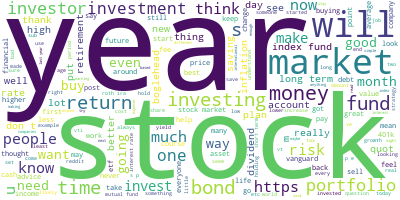

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(VG_df['textClean'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [12]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = VG_df.textClean.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobelder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['mid', 'working', 'financial', 'sector', 'adding', 'vt', 'bnd', 'portfolio', 'every', 'month', 'wife', 'hand', 'working', 'mental', 'health', 'sector', 'proper', 'definition', 'risk', 'averse', 'person', 'talk', 'stocks', 'talk', 'crash', 'thing', 'salary', 'substantial', 'nothing', 'frugal']


In [13]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [14]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"https" + 0.008*"market" + 0.007*"years" + 0.006*"com" + 0.006*"www" '
  '+ 0.005*"year" + 0.005*"stocks" + 0.005*"like" + 0.005*"stock" + '
  '0.005*"investing"'),
 (1,
  '0.009*"market" + 0.008*"fund" + 0.006*"funds" + 0.006*"stocks" + 0.006*"us" '
  '+ 0.006*"years" + 0.006*"investing" + 0.006*"year" + 0.005*"https" + '
  '0.005*"money"'),
 (2,
  '0.008*"market" + 0.007*"stocks" + 0.005*"time" + 0.005*"bonds" + '
  '0.005*"returns" + 0.005*"long" + 0.005*"people" + 0.005*"money" + '
  '0.005*"investing" + 0.004*"stock"'),
 (3,
  '0.008*"like" + 0.007*"market" + 0.007*"stocks" + 0.006*"money" + '
  '0.005*"https" + 0.005*"fund" + 0.005*"funds" + 0.004*"year" + '
  '0.004*"investing" + 0.004*"stock"'),
 (4,
  '0.012*"market" + 0.009*"money" + 0.008*"years" + 0.007*"us" + 0.005*"time" '
  '+ 0.005*"investing" + 0.005*"would" + 0.005*"stocks" + 0.005*"year" + '
  '0.005*"long"')]


In [22]:
#import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis.gensim_models as gensimvis
import scipy

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, n_jobs=4)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jacobelder/opt

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.001048  0.005149       1        1  32.241388
1     -0.001091  0.001972       2        1  26.064715
4     -0.010166  0.006370       3        1  18.514581
0     -0.003661 -0.014659       4        1  16.248529
3      0.015965  0.001167       5        1   6.930786, topic_info=        Term        Freq       Total Category  logprob  loglift
355     like  363.000000  363.000000  Default  30.0000  30.0000
156    https  396.000000  396.000000  Default  29.0000  29.0000
365    money  499.000000  499.000000  Default  28.0000  28.0000
51    market  754.000000  754.000000  Default  27.0000  27.0000
127      com  318.000000  318.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
227    years   19.706041  474.699156   Topic5  -5.6866  -0.5126
56      much   17.063110  282.086194   Topic5  -5.8306  -0.1361
251     long   17.920176  344.788169   Topic5  -5.7816  -0.2878
203  returns   17.194858  349.225342   Topic5  -5.8229  -0.3419
184   people   16.696643  321.098517   Topic5  -5.8523  -0.2873

[432 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
6819      2  0.540107  accomplished
308       1  0.285916       account
308       2  0.347184       account
308       3  0.155212       account
308       4  0.151127       account
...     ...       ...           ...
304       5  0.067648     yesterday
2322      1  0.154058            yo
2322      2  0.616232            yo
2322      3  0.154058            yo
3097      4  0.633651          zone

[813 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

In [18]:
!pip install pyLDAvis